In [112]:
%pylab inline --no-import-all
import numpy
import sklearn.mixture
import pickle
from PIL import Image, ImageDraw
import animator
import IPython.display

Populating the interactive namespace from numpy and matplotlib


In [178]:
def plot_params(path):
    '''Plots the parameters of a given sequence'''
    titles = ['$ tx $', '$ ty $', '$ sx $', '$ sy $', '$ \\theta $', '$ \\theta_{pv}$', 'product', 'ratio']
    matplotlib.pyplot.figure()
    matplotlib.pyplot.gcf().subplots_adjust(bottom=0.0, hspace=0.0)
    for i in range(path.shape[1]):
        axes = matplotlib.pyplot.subplot(int(path.shape[1]/2),2,i+1)
        matplotlib.pyplot.plot(path[:,i])
        if i < path.shape[1]-1:
            matplotlib.pyplot.setp( axes.get_xticklabels(), visible=False)
        matplotlib.pyplot.ylabel(titles[i])

In [179]:
def draw_polygon(polygons, size=(640, 480), outlines=['red', 'green', 'blue']):
    '''Draws polygons over an image'''
    image = Image.new('RGBA', size)
    draw = ImageDraw.ImageDraw(image)
    for id, polygon in enumerate(polygons):
        draw.polygon(polygon, outline=outlines[id])
        for i in range(len(polygon)/2):
            draw.text(polygon[2*i:2*i+2], str(i), fill=outlines[id])
    return image

In [180]:
def box_video(output, boxData):
    '''Generates a video drawing the specified polygons'''
    sequence = (draw_polygon([boxes[i] for boxes in boxData]) for i in numpy.arange(len(predictedPointsList)))
    animator.frames2video(sequence, 30, output)
    videoSrc = 'data:video/mp4;base64,' + open(output, 'rb').read().encode('base64')
    videoTag = '<video controls width="320" height="240"><source src="{0}" type="video/mp4">Unsupported tag</video>'
    return videoTag.format(videoSrc)

In [181]:
#Load file with dictionary of each sequence trajectory parameters
trajFile = open('trajectoryParams.pkl', 'r')
trajectories = pickle.load(trajFile)
trajFile.close()

In [111]:
print 'Keys for {} sequences: {}'.format(len(trajectories.keys()), trajectories.keys())

Keys for 25 sequences: ['skating', 'bicycle', 'drunk', 'sphere', 'ball', 'gymnastics', 'hand1', 'hand2', 'diving', 'fish2', 'fish1', 'basketball', 'sunshade', 'polarbear', 'woman', 'bolt', 'surfing', 'tunnel', 'car', 'torus', 'fernando', 'david', 'jogging', 'trellis', 'motocross']


In [182]:
#Parameters of sample trajectories and accumulator
LENGTH = 60
N_FEATURES = 4
samples = numpy.empty((LENGTH, N_FEATURES))

In [185]:
#Trajectory subsampling and original trajectory plots
totalLength = 0
for aSequence in trajectories.keys():
    trajectory = trajectories[aSequence]
    totalLength += trajectory.shape[0]
    print '{} length: {}'.format(aSequence, trajectory.shape)
    #plot_params(trajectory)
    for start in numpy.arange(0, trajectory.shape[0]-LENGTH, LENGTH):
        sample = trajectories[aSequence][start:start+LENGTH,:N_FEATURES]
        samples = numpy.dstack([samples, sample])
print 'Total length: {}'.format(totalLength)

skating length: (400, 8)
bicycle length: (271, 8)
drunk length: (1210, 8)
sphere length: (201, 8)
ball length: (603, 8)
gymnastics length: (207, 8)
hand1 length: (244, 8)
hand2 length: (267, 8)
diving length: (219, 8)
fish2 length: (310, 8)
fish1 length: (436, 8)
basketball length: (725, 8)
sunshade length: (172, 8)
polarbear length: (371, 8)
woman length: (597, 8)
bolt length: (350, 8)
surfing length: (282, 8)
tunnel length: (731, 8)
car length: (252, 8)
torus length: (264, 8)
fernando length: (292, 8)
david length: (770, 8)
jogging length: (307, 8)
trellis length: (569, 8)
motocross length: (164, 8)
Total length: 10214


In [186]:
#Shape and reshape debugging 
print samples.shape
flatSample = samples.reshape(LENGTH*N_FEATURES, samples.shape[2]).T
print flatSample.shape
print (flatSample.T[:,0].reshape(LENGTH, N_FEATURES)-samples[0:LENGTH,:,0]).sum()

(60, 4, 160)
(160, 240)
0.0


In [188]:
#GMM training and sampling
MIXTURES = 80
gmm = sklearn.mixture.GMM(n_components=MIXTURES, )
%time gmm.fit(flatSample)
%time predictedSamples = gmm.sample(n_samples=samples.shape[-1])

CPU times: user 268 ms, sys: 0 ns, total: 268 ms
Wall time: 267 ms
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 10.1 ms


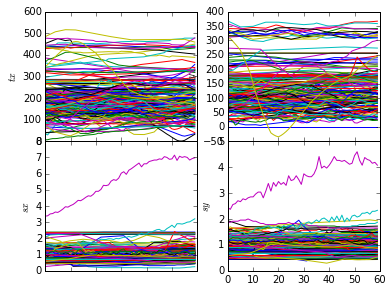

In [189]:
#Plot of samples
plot_params(samples.reshape(LENGTH, N_FEATURES, -1))

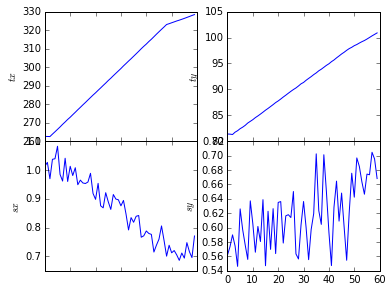

In [190]:
#Select a sample and plot boxes
predictedSample = predictedSamples[numpy.random.choice(predictedSamples.shape[0]),:].reshape(LENGTH, N_FEATURES)
plot_params(predictedSample)
predictedPointsList = []
refPoints = numpy.array([[0,100,100,0],[0,0,100,100],[1,1,1,1]])
#for tx, ty, sx, sy, theta, origTheta, product, ratio in predictedSample:
for tx, ty, sx, sy in predictedSample:
    theta = 0
    predictedTransform = numpy.array([[sx*numpy.cos(theta), sy*numpy.sin(theta), tx],[-sx*numpy.sin(theta), sy*numpy.cos(theta), ty],[0,0,1]])
    predictedPoints = numpy.dot(predictedTransform, refPoints)
    predictedPointsList.append(predictedPoints[:2,:].T.flatten())
IPython.display.HTML(box_video('/tmp/video.mp4', [[point.tolist() for point in predictedPointsList]]))

(302,)


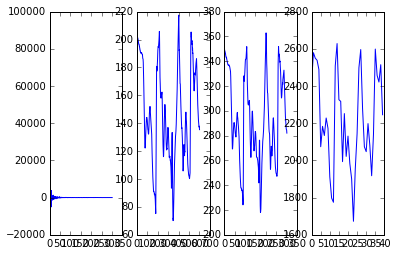

In [191]:
import numpy.fft
fft = numpy.fft.rfft(trajectories['ball'][:,0])
matplotlib.pyplot.subplot(1,4,1)
matplotlib.pyplot.plot(fft)
matplotlib.pyplot.subplot(1,4,2)
matplotlib.pyplot.plot(trajectories['ball'][:,0])
matplotlib.pyplot.subplot(1,4,3)
matplotlib.pyplot.plot(numpy.fft.ifft(fft))
matplotlib.pyplot.subplot(1,4,4)
matplotlib.pyplot.plot(numpy.fft.ifft(fft[:40]))
print fft.shape